# Table of Contents
 <p><div class="lev1 toc-item"><a href="#class-dev" data-toc-modified-id="class-dev-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>class dev</a></div><div class="lev1 toc-item"><a href="#try-across-parameter-space" data-toc-modified-id="try-across-parameter-space-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>try across parameter space</a></div>

In [1]:
# env source /Users/sebastian/work/git/stk/ml/waveforms/venv-wf/bin/activate

In [2]:
import sys
sys.path.append("../nonspin/")

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from waveform import SingleModeNRWaveform


from scipy.interpolate import InterpolatedUnivariateSpline as IUS

from scipy.optimize import least_squares

import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

/Users/sebastian/work/git/stk/ml/waveforms/venv-wf/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
nrfiles = [
    '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', #q=1
    '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
    '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5', #q=4
    '/Users/sebastian/work/data/SXS_BBH_0107_Res5.h5', #5
    '/Users/sebastian/work/data/SXS_BBH_0303_Res5.h5' #10
]


# class dev

In [219]:
class Model(object):
    def __init__(self, nrfile):
        self.nrfile = nrfile
        
        self.nrdata = self.load_nr_data(2,2,-600, 80)
#         self.nrdata = self.load_nr_data(4,4,-600, 80)
        
        
        self.q = self.nrdata.q
        eta, chi1z, chi2z = self.nrdata.eta, 0., 0.
        fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, fin_spin) * 2. * np.pi
        
        self.psi4 = self.compute_psi4(self.nrdata)
        self.compute_psi4_freq()
        
#         self.hlm = {}
#         self.news = {}
#         self.psi4 = {}
    
    def load_nr_data(self, ell, mm, t1, t2, npts_time=1000):
        """
        returns an instance of "SingleModeNRWaveform"
        ell, mm modes
        npts_time number of points to interpolate onto in range [t1,t2]
        """
        
        nrdata = SingleModeNRWaveform(self.nrfile, ell, mm, npts_time,t1=t1,t2=t2)
        
        return nrdata
    
#     def compute_news(self, nrdata):
#         """
#         nrdata is an instance of "SingleModeNRWaveform"
        
#         returns numpy array of news (news_real - 1.j*news_imag)
#         """
#         ihre = IUS(nrdata.times, nrdata.hlm.real)
#         ihim = IUS(nrdata.times, nrdata.hlm.imag)
        
#         newsre = ihre.derivative()(nrdata.times)
#         newsim = ihim.derivative()(nrdata.times)

#         news = newsre - 1.j*newsim
#         return news
    
    def compute_psi4(self, nrdata):
        """
        nrdata is an instance of "SingleModeNRWaveform"
        
        returns numpy array of psi4 (psi4_real - 1.j*psi4_imag)
        """
        ihre = IUS(nrdata.times, nrdata.hlm.real)
        ihim = IUS(nrdata.times, nrdata.hlm.imag)
        
        psi4re = ihre.derivative().derivative()(nrdata.times)
        psi4im = ihim.derivative().derivative()(nrdata.times)

        psi4 = psi4re - 1.j*psi4im
        return psi4
    
    def compute_psi4_freq(self):
        phi = np.unwrap(np.angle(self.psi4))
        iphi = IUS(self.nrdata.times, phi)
        self.psi4lmfreq = iphi.derivative()(self.nrdata.times)

    
    def late_frequency(self, params, t):
        a = params['a']
        b = params['b']
        c = params['c']
        d = params['d']
        model = (a*c) / ( (t-b)**2 + a**2 ) + d/(t-b)
        
        return model
    
    def late_frequency_to_min(self, params, t, data):
        model = self.late_frequency(params, t)
        return model - data
        
    def fit_late_frequency(self, t1=-200, t2=0):
        self.fit_late_frequency_mask = (self.nrdata.times > t1) & (self.nrdata.times < t2)
        t = self.nrdata.times[self.fit_late_frequency_mask]
        data = self.psi4lmfreq[self.fit_late_frequency_mask]
        
        # create a set of Parameters
        params = Parameters()
        params.add('a', value=20., min=1, max=2000)
        params.add('b', value=20, min=0, max=105)
        params.add('c', value=0., min=-200, max=10000)
        params.add('d', value=0., min=-200, max=200)
        
        fcn2min = self.late_frequency_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(t, data))
        
        self.late_frequency_result = minner.minimize()

        # calculate final result
        self.late_frequency_final = data + self.late_frequency_result.residual

        # write error report
        report_fit(self.late_frequency_result)

        
    def mr_frequency(self, params, t):
        
        t0 = params['t0']
        kappa = params['kappa']
        b = params['b']
        om_f = params['om_f']
        offset = params['offset']

        dt = t - t0
    #     num = 1. + np.tanh(np.log(np.sqrt(kappa)) - (dt/b))
        num = 1. + np.tanh((dt/b))
        den = 2.

        model = offset + (om_f - offset) * (num/den)**kappa
        
        return model
    
    def mr_frequency_to_min(self, params, t, data):
        model = self.mr_frequency(params, t)
        return model - data
        
    def fit_mr_frequency(self, t1=-20, t2=40):
        self.fit_mr_frequency_mask = (self.nrdata.times > t1) & (self.nrdata.times < t2)
        t = self.nrdata.times[self.fit_mr_frequency_mask]
        data = self.psi4lmfreq[self.fit_mr_frequency_mask]
        
        params = Parameters()
        
        
        print("need to fix these to amplitude values")
        params.add('t0', value=5., min=-10, max=200)
#         params.add('t0', value=tp_amp, vary=False)
        
        # params.add('kappa', value=1, min=1e-9, max=10)
        # params.add('kappa', value=0.25, vary=False) # bob value?
        params.add('kappa', value=0.36, vary=False) # best fit value?
        # params.add('b', value=1., min=1e-8, max=30)
        params.add('b', value=10., vary=False)
        # fixing b is ok but fitting is better
        # params.add('b', value=2./damping_time, vary=False)
        # params.add('om_f', value=fring * np.pi * 2, min=0.02, max=1)
        params.add('om_f', value=-self.fring, vary=False)
        params.add('offset', value=0., min=-200, max=200)
        
        
        fcn2min = self.mr_frequency_to_min
        minner = Minimizer(fcn2min, params, fcn_args=(t, data))
        
        self.mr_frequency_result = minner.minimize()

        # calculate final result
        self.mr_frequency_final = data + self.mr_frequency_result.residual

        # write error report
        report_fit(self.mr_frequency_result)
        


In [220]:
M1 = Model(nrfile=nrfiles[1])

In [221]:
M1.fit_late_frequency()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 294
    # variables        = 4
    chi-square         = 5.6294e-04
    reduced chi-square = 1.9412e-06
    Akaike info crit   = -3862.77897
    Bayesian info crit = -3848.04465
[[Variables]]
    a:  72.5883805 +/- 0.64407725 (0.89%) (init = 20)
    b:  43.7352963 +/- 0.30763780 (0.70%) (init = 20)
    c:  38.0981413 +/- 0.30207078 (0.79%) (init = 0)
    d:  32.6861135 +/- 0.20266802 (0.62%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.982
    C(c, d) =  0.972
    C(a, d) =  0.933
    C(b, d) =  0.901
    C(a, c) =  0.831
    C(b, c) =  0.777


In [222]:
M1.fit_mr_frequency()

need to fix these to amplitude values
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 88
    # variables        = 2
    chi-square         = 4.1139e-04
    reduced chi-square = 4.7836e-06
    Akaike info crit   = -1076.05032
    Bayesian info crit = -1071.09564
[[Variables]]
    t0:      6.37924371 +/- 0.05787788 (0.91%) (init = 5)
    kappa:   0.36 (fixed)
    b:       10 (fixed)
    om_f:   -0.5224378 (fixed)
    offset: -0.15731351 +/- 9.4376e-04 (0.60%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, offset) = -0.798


In [223]:
M1.late_frequency_result.params

Parameters([('a',
             <Parameter 'a', value=72.5883805334343 +/- 0.644, bounds=[1:2000]>),
            ('b',
             <Parameter 'b', value=43.735296299996996 +/- 0.308, bounds=[0:105]>),
            ('c',
             <Parameter 'c', value=38.09814131323904 +/- 0.302, bounds=[-200:10000]>),
            ('d',
             <Parameter 'd', value=32.68611349905052 +/- 0.203, bounds=[-200:200]>)])

In [224]:
M1.late_frequency_result.params['a']

<Parameter 'a', value=72.5883805334343 +/- 0.644, bounds=[1:2000]>

(-0.6, 0)

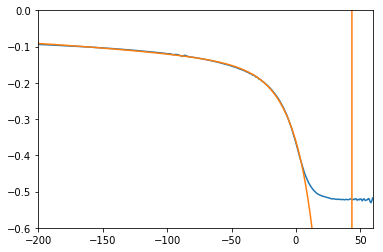

In [225]:
plt.figure()
plt.plot(M1.nrdata.times, M1.psi4lmfreq)
plt.plot(M1.nrdata.times, M1.late_frequency(M1.late_frequency_result.params,M1.nrdata.times))
plt.xlim(-200,60)
plt.ylim(-0.6,0)

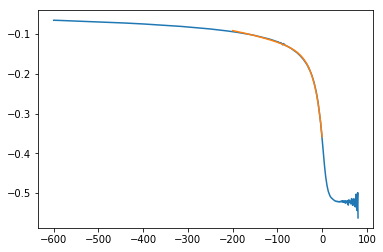

In [226]:
plt.figure()
plt.plot(M1.nrdata.times, M1.psi4lmfreq)
plt.plot(M1.nrdata.times[M1.fit_late_frequency_mask], M1.late_frequency_final)

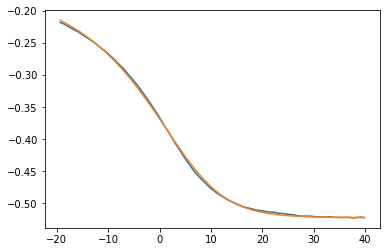

In [227]:
plt.figure()
# plt.plot(M1.nrdata.times, M1.psi4lmfreq)
plt.plot(M1.nrdata.times[M1.fit_mr_frequency_mask], M1.psi4lmfreq[M1.fit_mr_frequency_mask])
plt.plot(M1.nrdata.times[M1.fit_mr_frequency_mask], M1.mr_frequency_final)

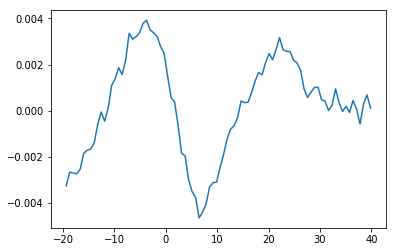

In [228]:
plt.figure()
# plt.plot(M1.nrdata.times, M1.psi4lmfreq)
plt.plot(M1.nrdata.times[M1.fit_mr_frequency_mask], M1.psi4lmfreq[M1.fit_mr_frequency_mask]-M1.mr_frequency_final)

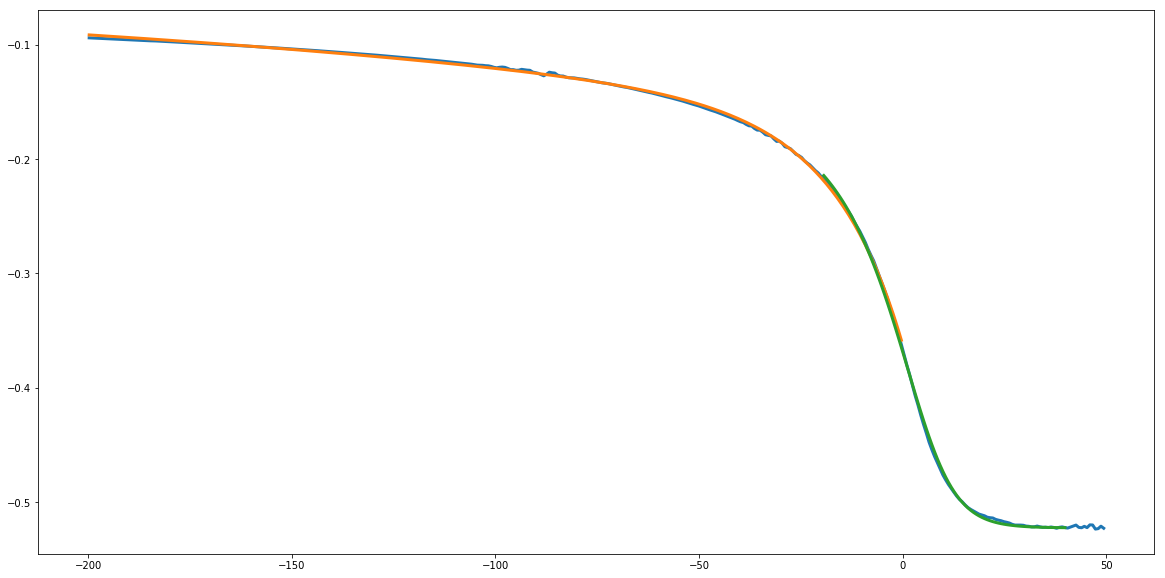

In [247]:
plt.figure(figsize=(20,10))
mask1 = (M1.nrdata.times > -200) & (M1.nrdata.times < 50)
plt.plot(M1.nrdata.times[mask1], M1.psi4lmfreq[mask1], lw=3)
plt.plot(M1.nrdata.times[M1.fit_late_frequency_mask], M1.late_frequency_final, lw=3)
plt.plot(M1.nrdata.times[M1.fit_mr_frequency_mask], M1.mr_frequency_final, lw=3)

In [230]:
# M1.nrfile

In [231]:
M1.compute_news()

AttributeError: 'Model' object has no attribute 'compute_news'

In [ ]:
M1 = Model(nrfiles=[1,2,3])

M1.fit_amplitude_

In [ ]:
for nr in nrfiles:

In [ ]:
list of nr files
that i want to loop over and
compute the coefficients of various models


models are defined by
1. ansatz
2. fit region
3. data to fit


# try across parameter space

In [232]:
Models = [Model(nrfile=nrfile) for nrfile in nrfiles]

In [233]:
[model.fit_late_frequency() for model in Models]

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 294
    # variables        = 4
    chi-square         = 5.4556e-04
    reduced chi-square = 1.8812e-06
    Akaike info crit   = -3871.99961
    Bayesian info crit = -3857.26529
[[Variables]]
    a:  71.7956202 +/- 0.61795753 (0.86%) (init = 20)
    b:  42.2945955 +/- 0.28426749 (0.67%) (init = 20)
    c:  36.4715775 +/- 0.28643161 (0.79%) (init = 0)
    d:  31.7545441 +/- 0.19051964 (0.60%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) =  0.982
    C(c, d) =  0.972
    C(a, d) =  0.929
    C(b, d) =  0.900
    C(a, c) =  0.827
    C(b, c) =  0.775
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 294
    # variables        = 4
    chi-square         = 5.6294e-04
    reduced chi-square = 1.9412e-06
    Akaike info crit   = -3862.77897
    Bayesian info crit = -3848.04465
[[Variables]]
    a:  72.58

[None, None, None, None, None]

In [234]:
[model.fit_mr_frequency() for model in Models]

need to fix these to amplitude values
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 88
    # variables        = 2
    chi-square         = 7.1480e-04
    reduced chi-square = 8.3116e-06
    Akaike info crit   = -1027.43439
    Bayesian info crit = -1022.47971
[[Variables]]
    t0:      7.10118200 +/- 0.06967550 (0.98%) (init = 5)
    kappa:   0.36 (fixed)
    b:       10 (fixed)
    om_f:   -0.5534662 (fixed)
    offset: -0.16078769 +/- 0.00119375 (0.74%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, offset) = -0.791
need to fix these to amplitude values
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 88
    # variables        = 2
    chi-square         = 4.1139e-04
    reduced chi-square = 4.7836e-06
    Akaike info crit   = -1076.05032
    Bayesian info crit = -1071.09564
[[Variables]]
    t0:      6.37924371 +/- 0.05787788 (0.91%) (init = 

[None, None, None, None, None]

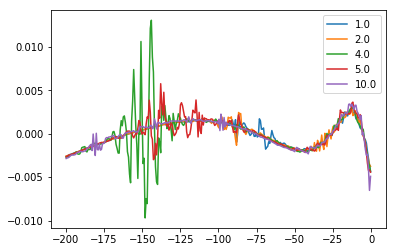

In [235]:
plt.figure()
# plt.plot(M1.nrdata.times, M1.psi4lmfreq)

for model in Models:
    plt.plot(model.nrdata.times[model.fit_late_frequency_mask], model.psi4lmfreq[model.fit_late_frequency_mask]-model.late_frequency_final, label="{:.1f}".format(model.q))
    
plt.legend()

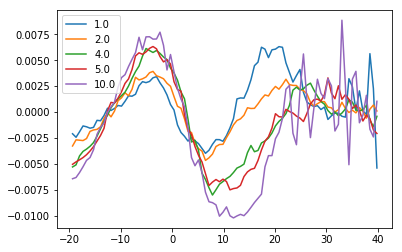

In [236]:
plt.figure()
# plt.plot(M1.nrdata.times, M1.psi4lmfreq)

for model in Models:
    plt.plot(model.nrdata.times[model.fit_mr_frequency_mask], model.psi4lmfreq[model.fit_mr_frequency_mask]-model.mr_frequency_final, label="{:.1f}".format(model.q))
    
plt.legend()

In [237]:
Models[0].late_frequency_result.params

Parameters([('a',
             <Parameter 'a', value=71.79562017075942 +/- 0.618, bounds=[1:2000]>),
            ('b',
             <Parameter 'b', value=42.294595524361405 +/- 0.284, bounds=[0:105]>),
            ('c',
             <Parameter 'c', value=36.47157749416024 +/- 0.286, bounds=[-200:10000]>),
            ('d',
             <Parameter 'd', value=31.75454414414807 +/- 0.191, bounds=[-200:200]>)])

In [238]:
q_list = ["{:.2f}".format(model.q) for model in Models]

In [239]:
q_list

['1.00', '2.00', '4.00', '5.00', '10.00']

In [240]:
[model.late_frequency_result.params['a'].value for model in Models]

[71.79562017075942,
 72.5883805334343,
 74.46486761147436,
 75.19877383996351,
 78.46461756355504]

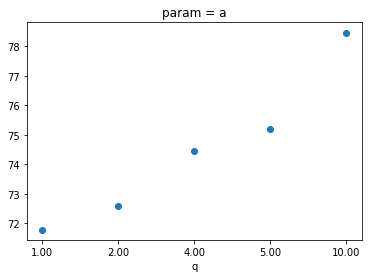

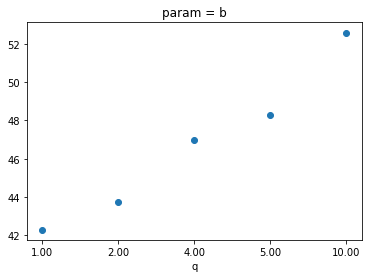

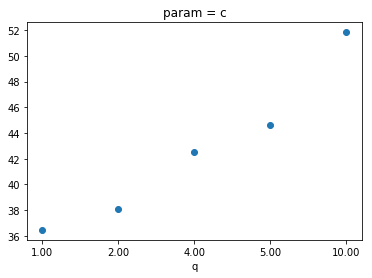

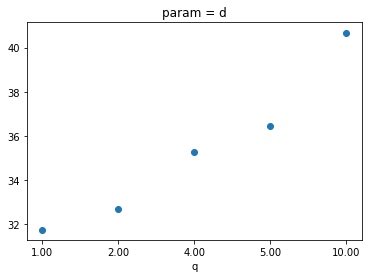

In [241]:
names = Models[0].late_frequency_result.params.keys()
for name in names:
    plt.figure()
    plt.scatter(q_list, [model.late_frequency_result.params[name].value for model in Models])
    plt.title('param = {}'.format(name))
    plt.xlabel('q')

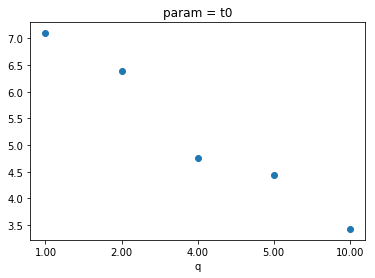

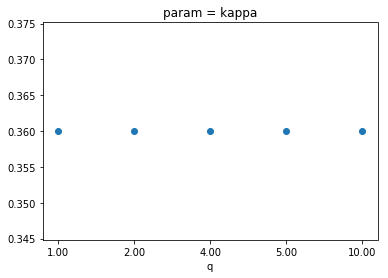

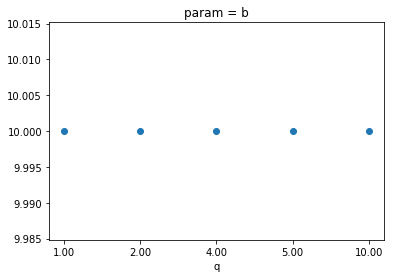

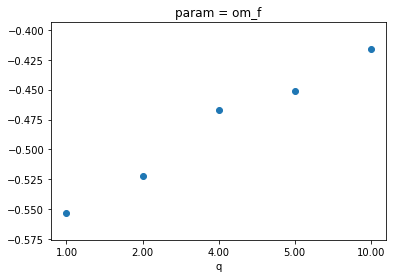

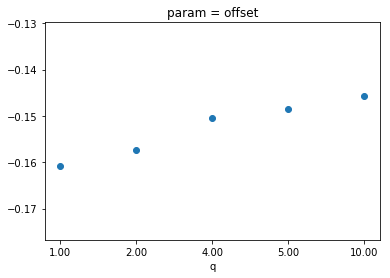

In [242]:
names = Models[0].mr_frequency_result.params.keys()
for name in names:
    plt.figure()
    plt.scatter(q_list, [model.mr_frequency_result.params[name].value for model in Models])
    plt.title('param = {}'.format(name))
    plt.xlabel('q')